### follows the work of Bengio et.al 2003
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

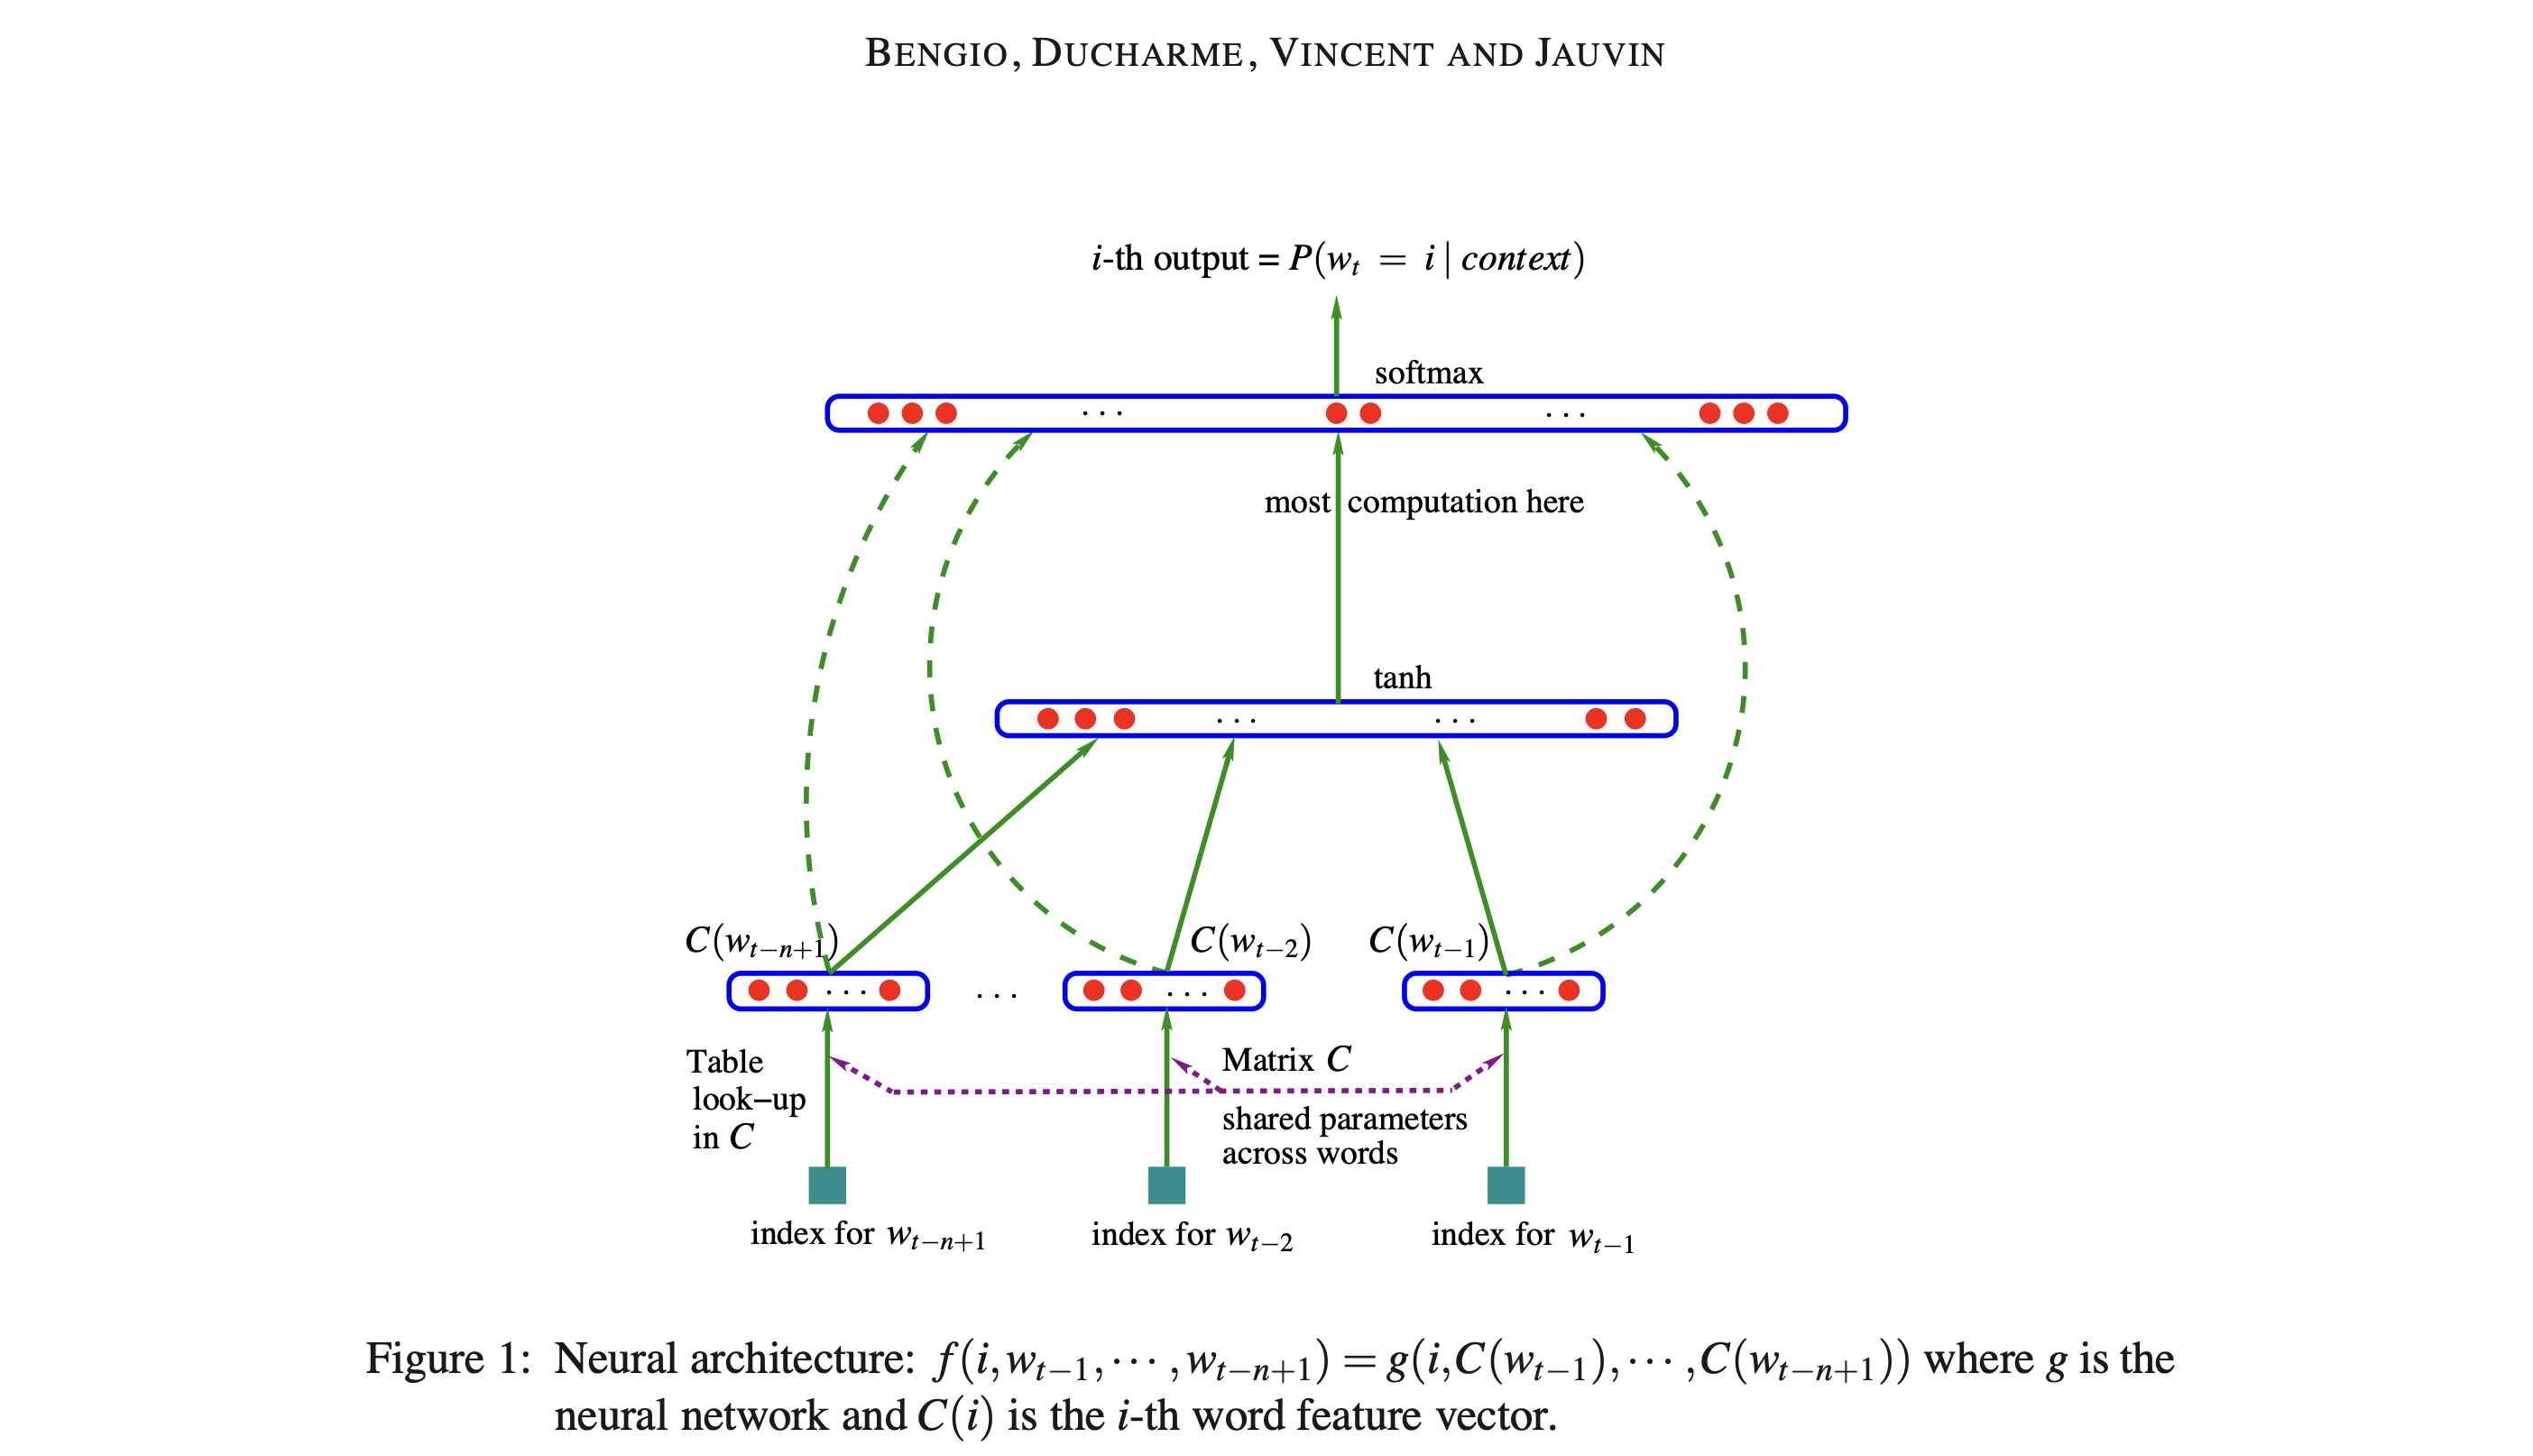

In [1]:
import pandas as pd
# so we will be making the lookup table (embedding space C) here.
# this paper was published for transduction tasks but we will generalize it for a tabular structure
from IPython.display import Image
Image("bengio2003.png")

In [2]:
# design choices :
# we could make a lookup table for each categorical column seperately too .. but we will follow the paper verbatim for now
# or we could make a generalized lookup table (we could discuss this in the next meetting)

In [3]:
# we will look at a simpler dataframe . (This is only the categorical columns of the income dataset)
import pandas as pd
income = pd.read_csv("cat_income.csv",index_col=0)
income

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,?,HS-grad,Widowed,?,Not-in-family,White,Female,United-States,<=50K
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K
2,?,Some-college,Widowed,?,Unmarried,Black,Female,United-States,<=50K
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K
...,...,...,...,...,...,...,...,...,...
32556,Private,Some-college,Never-married,Protective-serv,Not-in-family,White,Male,United-States,<=50K
32557,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
32558,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
32559,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K


In [4]:
# the combined vovabulary of the dataset is :
import numpy as np
vocab = []
for col in income.columns:
    vocab.append(income[col].unique())
vocab = np.hstack(vocab)
vocab = np.unique(vocab)
vocab

array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
       '<=50K', '>50K', '?', 'Adm-clerical', 'Amer-Indian-Eskimo',
       'Armed-Forces', 'Asian-Pac-Islander', 'Assoc-acdm', 'Assoc-voc',
       'Bachelors', 'Black', 'Cambodia', 'Canada', 'China', 'Columbia',
       'Craft-repair', 'Cuba', 'Divorced', 'Doctorate',
       'Dominican-Republic', 'Ecuador', 'El-Salvador', 'England',
       'Exec-managerial', 'Farming-fishing', 'Federal-gov', 'Female',
       'France', 'Germany', 'Greece', 'Guatemala', 'HS-grad', 'Haiti',
       'Handlers-cleaners', 'Holand-Netherlands', 'Honduras', 'Hong',
       'Hungary', 'Husband', 'India', 'Iran', 'Ireland', 'Italy',
       'Jamaica', 'Japan', 'Laos', 'Local-gov', 'Machine-op-inspct',
       'Male', 'Married-AF-spouse', 'Married-civ-spouse',
       'Married-spouse-absent', 'Masters', 'Mexico', 'Never-married',
       'Never-worked', 'Nicaragua', 'Not-in-family', 'Other',
       'Other-relative', 'Other-service', 'Outlying-US(Guam-

In [5]:
# there are 9 columns so we will use all the context window as 9
# we  will use the start token as <start> and the end token as <end>
# so lets make a simpler lookup table.
vocab = list(vocab)
vocab.append("<start>")
vocab.append("<end>")
vocab.append("<blank>")


In [6]:
vocab = set(vocab) # just to be double sure 😅
assert len(vocab) == 105 # as before
vocab

{'10th',
 '11th',
 '12th',
 '1st-4th',
 '5th-6th',
 '7th-8th',
 '9th',
 '<=50K',
 '<blank>',
 '<end>',
 '<start>',
 '>50K',
 '?',
 'Adm-clerical',
 'Amer-Indian-Eskimo',
 'Armed-Forces',
 'Asian-Pac-Islander',
 'Assoc-acdm',
 'Assoc-voc',
 'Bachelors',
 'Black',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Craft-repair',
 'Cuba',
 'Divorced',
 'Doctorate',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'Exec-managerial',
 'Farming-fishing',
 'Federal-gov',
 'Female',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'HS-grad',
 'Haiti',
 'Handlers-cleaners',
 'Holand-Netherlands',
 'Honduras',
 'Hong',
 'Hungary',
 'Husband',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Local-gov',
 'Machine-op-inspct',
 'Male',
 'Married-AF-spouse',
 'Married-civ-spouse',
 'Married-spouse-absent',
 'Masters',
 'Mexico',
 'Never-married',
 'Never-worked',
 'Nicaragua',
 'Not-in-family',
 'Other',
 'Other-relative',
 'Other-service',
 'Outlying-US(Guam-US

In [7]:
vtoi = dict() # lookup for vacb to idx
itov = dict() # reverse lookup

for i,v in enumerate(vocab):
    vtoi[v]=i

itov = {i:v for v,i in vtoi.items()}

In [8]:
vtoi

{'Married-spouse-absent': 0,
 '5th-6th': 1,
 'Ireland': 2,
 'Columbia': 3,
 'Female': 4,
 'Doctorate': 5,
 '12th': 6,
 'Trinadad&Tobago': 7,
 'Dominican-Republic': 8,
 'Preschool': 9,
 'Tech-support': 10,
 'Guatemala': 11,
 'Other-service': 12,
 'Local-gov': 13,
 '1st-4th': 14,
 'Honduras': 15,
 'HS-grad': 16,
 'Handlers-cleaners': 17,
 'Never-married': 18,
 'Jamaica': 19,
 'Not-in-family': 20,
 'Assoc-acdm': 21,
 'Armed-Forces': 22,
 '<start>': 23,
 'Husband': 24,
 'Machine-op-inspct': 25,
 'Amer-Indian-Eskimo': 26,
 '7th-8th': 27,
 'India': 28,
 'Self-emp-not-inc': 29,
 'Philippines': 30,
 'Nicaragua': 31,
 '11th': 32,
 'Scotland': 33,
 'Separated': 34,
 'Peru': 35,
 'Adm-clerical': 36,
 'Cuba': 37,
 'Divorced': 38,
 '<=50K': 39,
 'Married-AF-spouse': 40,
 'United-States': 41,
 'Haiti': 42,
 'Puerto-Rico': 43,
 'Private': 44,
 'Some-college': 45,
 'State-gov': 46,
 'Germany': 47,
 'Poland': 48,
 'Transport-moving': 49,
 '<end>': 50,
 'Canada': 51,
 'Priv-house-serv': 52,
 '9th': 53,


In [9]:
# remember the start and end tokens
vtoi["<start>"] , vtoi["<end>"] , vtoi["<blank>"]

(23, 50, 55)

In [10]:
# now lets build the dataset
import torch
import torch.nn.functional as F

In [11]:
income_copy = income.copy(deep=True)
income_copy.insert(0, "start","<start>") 
income_copy["end"] = "<end>"


In [12]:
income_encoded = income_copy.replace(vtoi)
income_encoded

,start,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income,end
0,23,91,16,77,91,20,68,4,41,39,50
1,23,44,16,77,64,20,68,4,41,39,50
2,23,91,45,77,91,80,85,4,41,39,50
3,23,44,27,38,25,80,68,4,41,39,50
4,23,44,45,34,60,94,68,4,41,39,50
...,...,...,...,...,...,...,...,...,...,...,...
32556,23,44,45,18,79,20,68,76,41,39,50
32557,23,44,21,90,10,74,68,4,41,39,50
32558,23,44,16,90,25,24,68,76,41,100,50
32559,23,44,16,77,36,80,68,4,41,39,50


In [13]:
# this is how we would do it if we dont record a row at the same time
# that is the entry gets streamed in the order of the rows given (not our case here)
for i,row in income_encoded[:3].iterrows():
    context = [0]*(len(income.columns)+1) # take account of start token
    # predict start 
    for column in income_copy.columns:
        print(context,"->",itov[ row[column]])
        context = context[1:] + [row[column]]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -> <start>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 23] -> ?
[0, 0, 0, 0, 0, 0, 0, 0, 23, 91] -> HS-grad
[0, 0, 0, 0, 0, 0, 0, 23, 91, 16] -> Widowed
[0, 0, 0, 0, 0, 0, 23, 91, 16, 77] -> ?
[0, 0, 0, 0, 0, 23, 91, 16, 77, 91] -> Not-in-family
[0, 0, 0, 0, 23, 91, 16, 77, 91, 20] -> White
[0, 0, 0, 23, 91, 16, 77, 91, 20, 68] -> Female
[0, 0, 23, 91, 16, 77, 91, 20, 68, 4] -> United-States
[0, 23, 91, 16, 77, 91, 20, 68, 4, 41] -> <=50K
[23, 91, 16, 77, 91, 20, 68, 4, 41, 39] -> <end>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -> <start>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 23] -> Private
[0, 0, 0, 0, 0, 0, 0, 0, 23, 44] -> HS-grad
[0, 0, 0, 0, 0, 0, 0, 23, 44, 16] -> Widowed
[0, 0, 0, 0, 0, 0, 23, 44, 16, 77] -> Exec-managerial
[0, 0, 0, 0, 0, 23, 44, 16, 77, 64] -> Not-in-family
[0, 0, 0, 0, 23, 44, 16, 77, 64, 20] -> White
[0, 0, 0, 23, 44, 16, 77, 64, 20, 68] -> Female
[0, 0, 23, 44, 16, 77, 64, 20, 68, 4] -> United-States
[0, 23, 44, 16, 77, 64, 20, 68, 4, 41] -> <=50K
[23, 44, 16, 77

In [14]:
# for our case all entries will have a context from all the other columns
# this is more of a fill in the blanks problem...(we will only assume 1 blank for now)
# if there are more than 1 missing values in the frame .. we will be out of distribution
# (we can discuss this further)
for row in income_encoded[:3].itertuples(index=False, name=None):
    # each examples
    ex = np.array( row[1:-1]) # without the start and end tokens
    for idx,val in enumerate(ex):
        response = ex[idx]
        ex[idx]= vtoi["<blank>"]
        context = ex
        print(context,"->",response)
        # reset ex
        ex[idx] = response
        
        



[55 16 77 91 20 68  4 41 39] -> 91
[91 55 77 91 20 68  4 41 39] -> 16
[91 16 55 91 20 68  4 41 39] -> 77
[91 16 77 55 20 68  4 41 39] -> 91
[91 16 77 91 55 68  4 41 39] -> 20
[91 16 77 91 20 55  4 41 39] -> 68
[91 16 77 91 20 68 55 41 39] -> 4
[91 16 77 91 20 68  4 55 39] -> 41
[91 16 77 91 20 68  4 41 55] -> 39
[55 16 77 64 20 68  4 41 39] -> 44
[44 55 77 64 20 68  4 41 39] -> 16
[44 16 55 64 20 68  4 41 39] -> 77
[44 16 77 55 20 68  4 41 39] -> 64
[44 16 77 64 55 68  4 41 39] -> 20
[44 16 77 64 20 55  4 41 39] -> 68
[44 16 77 64 20 68 55 41 39] -> 4
[44 16 77 64 20 68  4 55 39] -> 41
[44 16 77 64 20 68  4 41 55] -> 39
[55 45 77 91 80 85  4 41 39] -> 91
[91 55 77 91 80 85  4 41 39] -> 45
[91 45 55 91 80 85  4 41 39] -> 77
[91 45 77 55 80 85  4 41 39] -> 91
[91 45 77 91 55 85  4 41 39] -> 80
[91 45 77 91 80 55  4 41 39] -> 85
[91 45 77 91 80 85 55 41 39] -> 4
[91 45 77 91 80 85  4 55 39] -> 41
[91 45 77 91 80 85  4 41 55] -> 39


In [15]:
# and now we can go ahead and compile the dataset
X = []
y = []

for row in income_encoded.itertuples(index=False, name=None):
    # each examples
    ex = np.array( row[1:-1]) # without the start and end tokens
    for idx,val in enumerate(ex):
        response = ex[idx]
        ex[idx]= vtoi["<blank>"]
        context = ex
        # print(context,"->",response)
        # reset ex
        ex[idx] = response
        X.append(context)
        y.append(response)
        
X = torch.tensor(X)
y = torch.tensor(y)

# X = F.one_hot(X).float()

/var/folders/f0/_f_gy0t91jqchv14f0hcl_gh0000gn/T/ipykernel_41312/4028358709.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403226260/work/torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(X)


In [17]:
X.shape

torch.Size([293049, 9])

In [16]:
tot_examples = X.shape[0]
X.shape , y.shape # so we have 293049 examples and each example is of shape 9,105 (the same as context window, vocab size)

(torch.Size([293049, 9, 105]), torch.Size([293049]))

In [17]:
# we can flatten this X
# Note use view instead of unbind and concat
# as view does not make a new storage .

X.view(tot_examples,-1).shape

torch.Size([293049, 945])

In [18]:
from sklearn.model_selection import train_test_split
X_tr, X_test, y_tr, y_test = train_test_split(X.view(tot_examples,-1), y, test_size=0.2, random_state=42)
X_va, X_ts, y_va, y_ts = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [19]:
# train , validation and test
print(X_tr.shape, X_va.shape, X_ts.shape)
print(y_tr.shape, y_va.shape, y_ts.shape)

torch.Size([234439, 945]) torch.Size([29305, 945]) torch.Size([29305, 945])
torch.Size([234439]) torch.Size([29305]) torch.Size([29305])


In [20]:
# since our Vocab size is high (for my computer :) )
# lets just project it into a 2 dimensional embedding also its easier to plot

g = torch.Generator().manual_seed(123)
C = torch.randn(X_tr.shape[1],2,generator=g) # this is the same C as in the paper (see image)
# since this C is going to be right Multilied
# C : R945 -> R2
embd = X_tr @ C
embd.shape, C.shape

(torch.Size([234439, 2]), torch.Size([945, 2]))

In [21]:
# the paper uses a very small neural network for its experiments and gets good result (for 2003)
# so we will start with the same ; good for reproducibility

W1 = torch.randn(2,200, generator=g) # after embedding each example will be R2 we push it to 100 with this layer
b1 = torch.randn(200,generator=g) # each neuron gets a bias.

# prove the broadcasting works fine here. (first we right align the dimesion)
# embd @ W1 : ex,2 x 2,200 = ex,200
# emb @ W1 : ex,200
# b1       :   ,200

# if the dimesion is missing we add 1,
# emb @ W1 : ex,200
# b1       : 1,200

# so to broadcast we will be copying the bias vector (row vector)
# for every row to make it the shape of ex,100 shape.
# that is each example recieves the same bias

In [22]:
# the first layer gets actvated with tanh (see paper). and the second layer is a linear layer
# the output layer is the desired shape of our logits prob of vocab
W2 = torch.randn(200,105,generator=g) 
b2 = torch.randn(105,generator=g)

In [23]:
# trainable parameters
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True

In [24]:
# so the forward pass looks like this
embd = X_tr @ C

# first layer
h1 =  torch.tanh((embd @ W1) + b1)
# second layer
logits = h1 @ W2 + b2

# we will use the same loss as the paper
# count = logits.exp()
# prob = count/count.sum(1,keepdim=True)
# guess = prob[torch.arange(1,X_tr.shape[0]),y_tr] # index the probability of making correct guess
# # and then negative mean log likelhood as the loss
# loss = -1 * guess.log().mean()

# but this is inefficient uses too much memory and not optimized for underflow and overflow of the logits
# so we will use the builtin cross entropy which arrives at the same loss but more efficiently 
loss = F.cross_entropy(logits,y_tr)

In [25]:
loss

tensor(34.3863, grad_fn=<NllLossBackward0>)

In [26]:
# and a backward pass would look like
# flush the gradients before backpropogation
for p in parameters:
    p.grad = None

# back propogation
loss.backward()

# learning step
lr = 0.1 # learning rate
for p in parameters:
    p.data = p.data - (0.1 * p.grad )

In [27]:
# rerun the forward pass again to see the loss is decreasing

In [28]:
# now we can make a training loop

def mini_batch(inp,out,size=64):
    indexes = torch.randint(low=0,high=inp.shape[0],size=(size,))
    return inp[indexes] , out[indexes] 
    

In [29]:
sx,sy = mini_batch(X_tr,y_tr)
sx.shape , sy.shape

(torch.Size([64, 945]), torch.Size([64]))

In [53]:
def learing_decay(start=0,min_rate=-2,tot=100):
    return torch.logspace(start,min_rate,tot)

In [54]:
# torch.logspace?/

In [55]:
# track
loss_tr = []

In [67]:
# implement simple decay
iters = 1000
for i in range(iters):
    X_sample,y_sample = mini_batch(X_tr,y_tr)
    lr = learing_decay(start=-2,min_rate=-4,tot=iters)
    embd =  X_sample @ C

    # first layer
    h1 =  torch.tanh((embd @ W1) + b1)
    # second layer
    logits = h1 @ W2 + b2

    loss = F.cross_entropy(logits,y_sample)
    loss_tr.append(loss.data)
    
    # prit stats
    print(f'Iter  :{i} running loss :{loss}')

    # flush grads before backpropogating
    for p in parameters:
        p.grad = None

    # back propogation
    loss.backward()

    # learning step
    for p in parameters:
        p.data = p.data - (lr[i] * p.grad )
    
    


Iter  :0 running loss :3.301983118057251
Iter  :1 running loss :3.5564844608306885
Iter  :2 running loss :3.2243340015411377
Iter  :3 running loss :3.7519912719726562
Iter  :4 running loss :3.2617571353912354
Iter  :5 running loss :3.314356803894043
Iter  :6 running loss :3.274070978164673
Iter  :7 running loss :3.4559619426727295
Iter  :8 running loss :3.4002504348754883
Iter  :9 running loss :3.875515937805176
Iter  :10 running loss :3.4061851501464844
Iter  :11 running loss :3.6686434745788574
Iter  :12 running loss :3.4574103355407715
Iter  :13 running loss :3.412872791290283
Iter  :14 running loss :3.448155403137207
Iter  :15 running loss :3.3529202938079834
Iter  :16 running loss :3.2287497520446777
Iter  :17 running loss :3.4721014499664307
Iter  :18 running loss :3.3403193950653076
Iter  :19 running loss :3.6112887859344482
Iter  :20 running loss :3.643970012664795
Iter  :21 running loss :3.375920534133911
Iter  :22 running loss :3.4565629959106445
Iter  :23 running loss :3.394

In [69]:
# the loss saturates at higher loss .
# but thats too be expected read concusion (Bengio)
# as the embedding space does not have enough capaacity to embed 105 voacbulary
# but this improves on RNN  methods from < 2002 

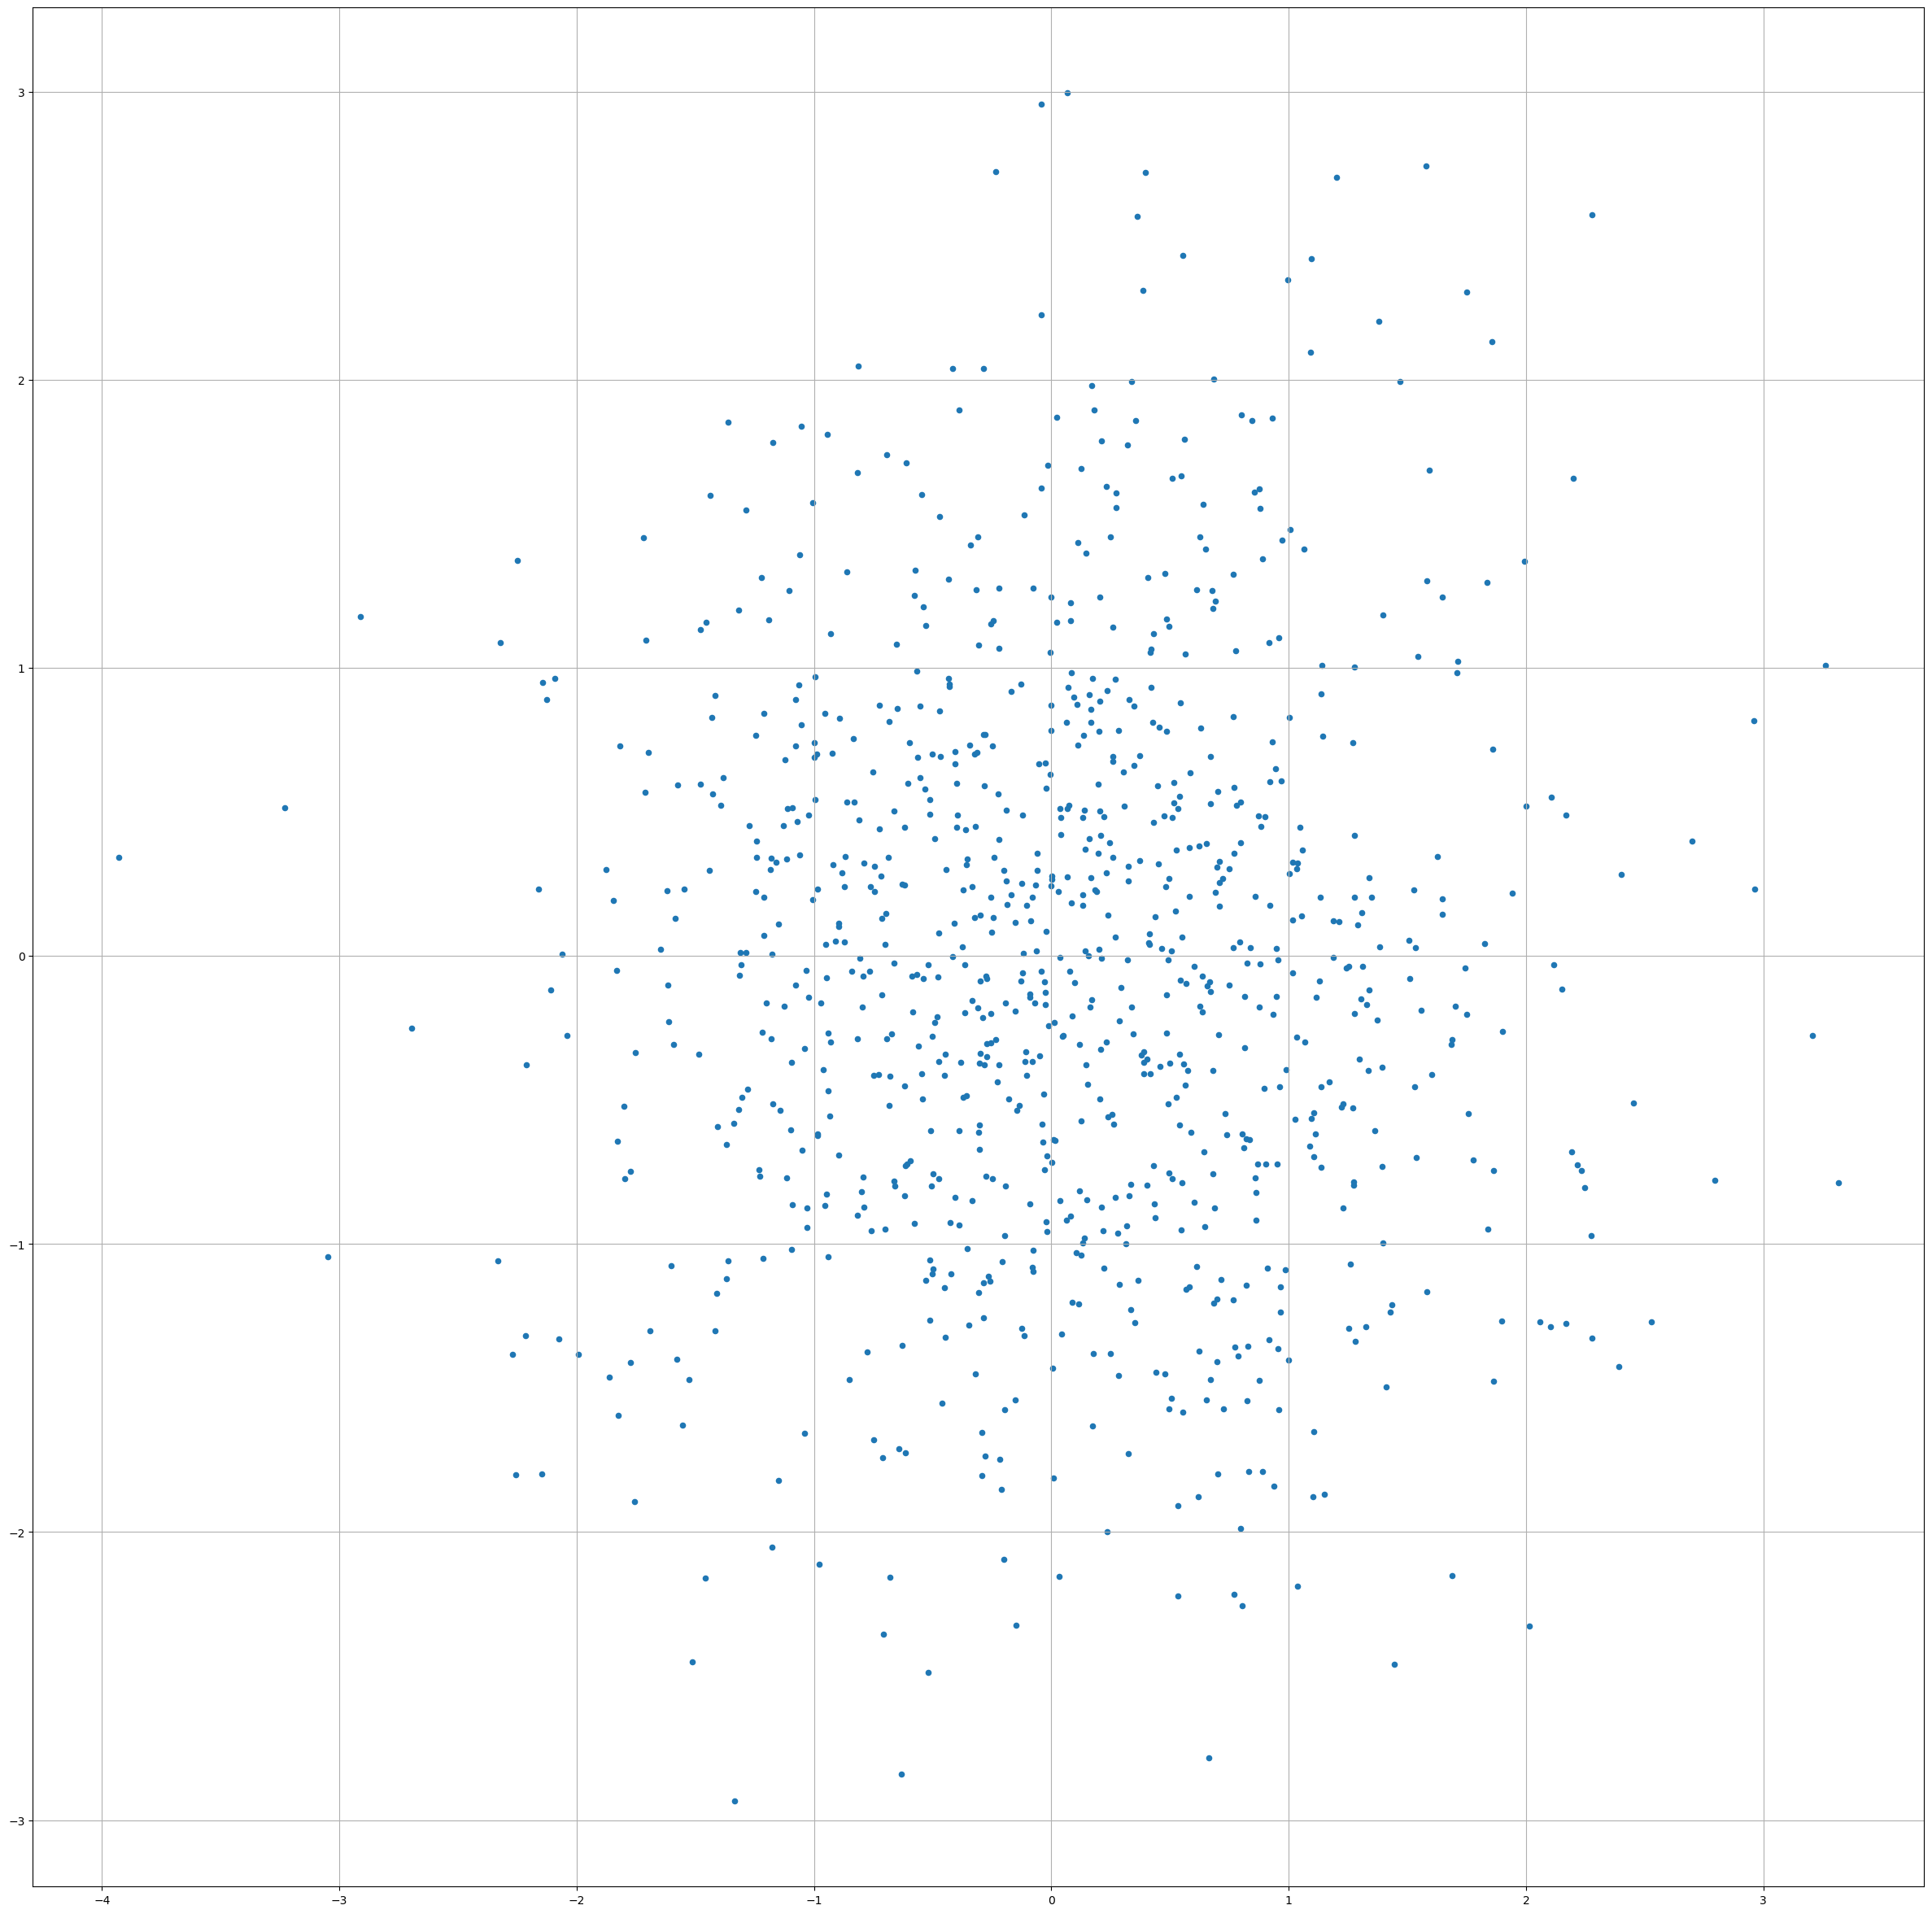

In [70]:
# visualize dimensions 0 and 1 of the embedding matrix C for all charactersn
# what we need here is a context embedding more than a word emedding .
# to calcualte conditional probabilities

# each dot is a context (945 dots) not a lot of seperation
# maybe we could project it higher and visualize it with pca biplots .. (discuss ?)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.scatter(C[:,0].data, C[:,1].data, s=20)
plt.grid('minor')